<a href="https://colab.research.google.com/github/wangyu16/PolymerScienceEducation/blob/master/OVESET/08_Self_Avoid_Chains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><a href="https://wangyu16.github.io/PolymerScienceEducation/"><img src="https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/master/Fig/Logo_black.svg" width='150' /></a></center>

# Self Avoid Chains

-----------

To learn the background knowledge, please visit this [study guide](https://hackmd.io/@YW2025/SyiT4N3A0).

## What does this simulator do?

Given chain length (the number of bonds $n$ in each chain),
1. generate chains based on hindered rotation and self-avoid hindered rotation models;  
2. calculate end to end distances $h$ and radius of gyrations ($R_g$) from two models;  
3. plot the distributions of $h$ and $R_g$, and calculate the mean values $\langle h^2\rangle$ of and $\langle R_g^2\rangle$.  

### Defination

The **self-avoid threshold** refers to the minimum allowable distance between two points along a chain, with the following exceptions:

* *Adjacent points*: These points have a fixed distance equal to the bond length (which is 1 in this simulation).
* *Two points two bonds apart*: The distance between these points is fixed at $2\sin\frac{\theta}{2}$​, where $\theta$ represents the bond angle.
* *Two points three bonds apart*: The minimum distance between these points is given by $[2\cos(\pi - \theta) + 1]$, and all torsion angles should be allowed.

To visualize this concept, consider a model chain resembling polyethylene. Notably, the self-avoid threshold should be greater than the bond length. Taking into account repulsive interactions between H atoms, the actual threshold could be as large as two bond lengths. For study purposes, you can set the threshold arbitrarily within this range.

## How to use this simulator?

Simply set the values in "Section 2. Simulation conditions" and run all cells. The results compare self-avoid chains and non-self-avoid chains by showing the difference of their end-to-end distances and radii of gyration.

## Simulation conditions

In [ ]:
#@title 1. Install and import packages {display-mode: "form" }
%%capture
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import cdist
import concurrent.futures
!pip install sigfig
from sigfig import round


In [ ]:
#@title 2. Simulation conditions. {display-mode: "form" }

#@markdown For self avoid chain, set the minimum allowed distance between two points.
selfAvoidThreshold = 1.5 #@param {type:"slider", min:1, max:2,step:0.1}
#@markdown The default value 109.5 is the bond angle found in polyethylene.
bondAngle = 109.5 #@param {type:"slider", min:105, max:175, step:0.1}
#@markdown The value of chainLength defines the number of bonds in each chain.
chainLength = 300 #@param {type:"slider", min:25, max:400, step:1}
numberOfChains = 1000

temperature = 298 # K
NA = 6.02e23 # Avogadro constant (/mol)
k = 1.38e-23 # Boltzmann constant (J/K)
# Energy levels associated with each degree of torsion angle.
# The conformaitonal energy is calculated from butane.
ELevels = np.array([0.00000000e+00, 7.54592315e-03, 2.92783051e-02, 6.51911715e-02,
       1.15278548e-01, 1.79534461e-01, 2.57952936e-01, 3.50527998e-01,
       4.57253674e-01, 5.78123989e-01, 7.13132969e-01, 8.62274640e-01,
       1.02554303e+00, 1.20293216e+00, 1.39443605e+00, 1.60004875e+00,
       1.81976426e+00, 2.05357661e+00, 2.30147984e+00, 2.56346797e+00,
       2.83953501e+00, 3.12967501e+00, 3.43388198e+00, 3.75214995e+00,
       4.08447295e+00, 4.43084499e+00, 4.79096456e+00, 5.16331162e+00,
       5.54605216e+00, 5.93735218e+00, 6.33537767e+00, 6.73829465e+00,
       7.14426909e+00, 7.55146701e+00, 7.95805439e+00, 8.36219723e+00,
       8.76206154e+00, 9.15581330e+00, 9.54161852e+00, 9.91764319e+00,
       1.02820533e+01, 1.06330149e+01, 1.09686939e+01, 1.12872563e+01,
       1.15868794e+01, 1.18664989e+01, 1.21262807e+01, 1.23665032e+01,
       1.25874446e+01, 1.27893832e+01, 1.29725974e+01, 1.31373654e+01,
       1.32839655e+01, 1.34126761e+01, 1.35237754e+01, 1.36175417e+01,
       1.36942534e+01, 1.37540310e+01, 1.37964215e+01, 1.38208411e+01,
       1.38267062e+01, 1.38134329e+01, 1.37804378e+01, 1.37271369e+01,
       1.36529467e+01, 1.35572834e+01, 1.34396658e+01, 1.33006901e+01,
       1.31415972e+01, 1.29636368e+01, 1.27680585e+01, 1.25561121e+01,
       1.23290470e+01, 1.20881131e+01, 1.18345599e+01, 1.15696370e+01,
       1.12945942e+01, 1.10106810e+01, 1.07191471e+01, 1.04212423e+01,
       1.01182160e+01, 9.81131794e+00, 9.50179781e+00, 9.19090523e+00,
       8.87988984e+00, 8.57000130e+00, 8.26248925e+00, 7.95860333e+00,
       7.65959320e+00, 7.36670850e+00, 7.08115647e+00, 6.80354801e+00,
       6.53405378e+00, 6.27283418e+00, 6.02004959e+00, 5.77586037e+00,
       5.54042692e+00, 5.31390962e+00, 5.09646885e+00, 4.88826499e+00,
       4.68945841e+00, 4.50020951e+00, 4.32067866e+00, 4.15102624e+00,
       3.99141264e+00, 3.84199823e+00, 3.70294340e+00, 3.57440853e+00,
       3.45655399e+00, 3.34954018e+00, 3.25352747e+00, 3.16867625e+00,
       3.09514688e+00, 3.03309976e+00, 2.98269527e+00, 2.94409379e+00,
       2.91745569e+00, 2.90294137e+00, 2.90071119e+00, 2.91092555e+00,
       2.93374482e+00, 2.96932938e+00, 3.01783962e+00, 3.07943666e+00,
       3.15443734e+00, 3.24350566e+00, 3.34735249e+00, 3.46668873e+00,
       3.60222527e+00, 3.75467301e+00, 3.92474283e+00, 4.11314564e+00,
       4.32059231e+00, 4.54779374e+00, 4.79546083e+00, 5.06430447e+00,
       5.35503554e+00, 5.66836495e+00, 6.00500357e+00, 6.36566231e+00,
       6.75105206e+00, 7.16188370e+00, 7.59886814e+00, 8.06271625e+00,
       8.55413894e+00, 9.07372111e+00, 9.61999247e+00, 1.01898089e+01,
       1.07799775e+01, 1.13873056e+01, 1.20086002e+01, 1.26406685e+01,
       1.32803176e+01, 1.39243549e+01, 1.45695873e+01, 1.52128221e+01,
       1.58508664e+01, 1.64805274e+01, 1.70986122e+01, 1.77019281e+01,
       1.82872822e+01, 1.88515041e+01, 1.93925323e+01, 1.99098968e+01,
       2.04032505e+01, 2.08722464e+01, 2.13165376e+01, 2.17357771e+01,
       2.21296178e+01, 2.24977128e+01, 2.28397151e+01, 2.31552777e+01,
       2.34440537e+01, 2.37056959e+01, 2.39398574e+01, 2.41461913e+01,
       2.43243505e+01, 2.44739881e+01, 2.45947570e+01, 2.46863103e+01,
       2.47483009e+01, 2.46863103e+01, 2.45947570e+01, 2.44739881e+01,
       2.43243505e+01, 2.41461913e+01, 2.39398574e+01, 2.37056959e+01,
       2.34440537e+01, 2.31552777e+01, 2.28397151e+01, 2.24977128e+01,
       2.21296178e+01, 2.17357771e+01, 2.13165376e+01, 2.08722464e+01,
       2.04032505e+01, 1.99098968e+01, 1.93925323e+01, 1.88515041e+01,
       1.82872822e+01, 1.77019281e+01, 1.70986122e+01, 1.64805274e+01,
       1.58508664e+01, 1.52128221e+01, 1.45695873e+01, 1.39243549e+01,
       1.32803176e+01, 1.26406685e+01, 1.20086002e+01, 1.13873056e+01,
       1.07799775e+01, 1.01898089e+01, 9.61999247e+00, 9.07372111e+00,
       8.55413894e+00, 8.06271625e+00, 7.59886814e+00, 7.16188370e+00,
       6.75105206e+00, 6.36566231e+00, 6.00500357e+00, 5.66836495e+00,
       5.35503554e+00, 5.06430447e+00, 4.79546083e+00, 4.54779374e+00,
       4.32059231e+00, 4.11314564e+00, 3.92474283e+00, 3.75467301e+00,
       3.60222527e+00, 3.46668873e+00, 3.34735249e+00, 3.24350566e+00,
       3.15443734e+00, 3.07943666e+00, 3.01783962e+00, 2.96932938e+00,
       2.93374482e+00, 2.91092555e+00, 2.90071119e+00, 2.90294137e+00,
       2.91745569e+00, 2.94409379e+00, 2.98269527e+00, 3.03309976e+00,
       3.09514688e+00, 3.16867625e+00, 3.25352747e+00, 3.34954018e+00,
       3.45655399e+00, 3.57440853e+00, 3.70294340e+00, 3.84199823e+00,
       3.99141264e+00, 4.15102624e+00, 4.32067866e+00, 4.50020951e+00,
       4.68945841e+00, 4.88826499e+00, 5.09646885e+00, 5.31390962e+00,
       5.54042692e+00, 5.77586037e+00, 6.02004959e+00, 6.27283418e+00,
       6.53405378e+00, 6.80354801e+00, 7.08115647e+00, 7.36670850e+00,
       7.65959320e+00, 7.95860333e+00, 8.26248925e+00, 8.57000130e+00,
       8.87988984e+00, 9.19090523e+00, 9.50179781e+00, 9.81131794e+00,
       1.01182160e+01, 1.04212423e+01, 1.07191471e+01, 1.10106810e+01,
       1.12945942e+01, 1.15696370e+01, 1.18345599e+01, 1.20881131e+01,
       1.23290470e+01, 1.25561121e+01, 1.27680585e+01, 1.29636368e+01,
       1.31415972e+01, 1.33006901e+01, 1.34396658e+01, 1.35572834e+01,
       1.36529467e+01, 1.37271369e+01, 1.37804378e+01, 1.38134329e+01,
       1.38267062e+01, 1.38208411e+01, 1.37964215e+01, 1.37540310e+01,
       1.36942534e+01, 1.36175417e+01, 1.35237754e+01, 1.34126761e+01,
       1.32839655e+01, 1.31373654e+01, 1.29725974e+01, 1.27893832e+01,
       1.25874446e+01, 1.23665032e+01, 1.21262807e+01, 1.18664989e+01,
       1.15868794e+01, 1.12872563e+01, 1.09686939e+01, 1.06330149e+01,
       1.02820533e+01, 9.91764319e+00, 9.54161852e+00, 9.15581330e+00,
       8.76206154e+00, 8.36219723e+00, 7.95805439e+00, 7.55146701e+00,
       7.14426909e+00, 6.73829465e+00, 6.33537767e+00, 5.93735218e+00,
       5.54605216e+00, 5.16331162e+00, 4.79096456e+00, 4.43084499e+00,
       4.08447295e+00, 3.75214995e+00, 3.43388198e+00, 3.12967501e+00,
       2.83953501e+00, 2.56346797e+00, 2.30147984e+00, 2.05357661e+00,
       1.81976426e+00, 1.60004875e+00, 1.39443605e+00, 1.20293216e+00,
       1.02554303e+00, 8.62274640e-01, 7.13132969e-01, 5.78123989e-01,
       4.57253674e-01, 3.50527998e-01, 2.57952936e-01, 1.79534461e-01,
       1.15278548e-01, 6.51911715e-02, 2.92783051e-02, 7.54592315e-03,
       ]) # kJ/mo

relativeProbs = np.exp(-1000*ELevels/NA/temperature/k)
probs = relativeProbs/relativeProbs.sum() # Normalized probabilities

#plt.plot(probs)
#plt.show()

bondAngle = bondAngle/180*np.pi


In [ ]:
# @title {display-mode: "form"}

class chain:
  """
  A class to represent a chain of n points in 3D space.
  """

  def __init__(self, points):
    """
    Initialize a chain object.
    Args:
      points: A series of n points in 3D space with their coordinates stored in a (n, 3) numpy array.
    """
    self.length = len(points) - 1
    self.coordinates = points

  @property
  def e2eDistance(self):
    """
    Calculate the end-to-end distance of the chain.
    Returns:
      The end-to-end distance of the chain.
    """
    return np.linalg.norm(self.coordinates[-1] - self.coordinates[0])

  @property
  def massCenter(self):
    """
    Calculate the mass center of the chain.
    Returns:
      The mass center of the chain.
    """
    return np.mean(self.coordinates, axis=0)

  @property
  def radiusGyration(self):
    """
    An alternative way to calculates the radius of gyration of the chain.
    Returns:
      The radius of gyration.
    """
    massCenter = self.massCenter
    squaredDistances = np.sum((self.coordinates - massCenter)**2, axis=1)
    return np.sqrt(np.mean(squaredDistances))

  @classmethod
  def fromAngles(cls, thetas, phis, chainLength):
    """
    An alternative constructor from given bond angles and torsion angles.
    Args:
      thetas: The bond angles in radians.
      phis: The torsion angles in radians.
      chainLength: number of bonds in each chain
    Returns:
      A chain object.
    """
    def rotateVectorZ(vectors, phi):
      """
      Rotate the vectors anticlockwise around z axis.
      Args:
        vectors: (3, n) array which contains n 3D vectors.
        phi: rotation angle in radians.
      Returns: (3, n) array which contains n 3D vectors rotated anticlockwise around z axis.
      """
      rotationMatrix = np.array([[np.cos(phi), -np.sin(phi), 0],
                                [np.sin(phi), np.cos(phi), 0],
                                [0, 0, 1]])
      return np.matmul(rotationMatrix, vectors)

    def rotateVectorY(vectors, theta):
      """
      Rotate the vectors anticlockwise around y axis.
      Args:
        vectors: (3, n) array which contains n 3D vectors.
      Returns: (3, n) array which contains n 3D vectors rotated anticlockwise around y axis.
      """
      rotationMatrix = np.array([[np.cos(theta), 0, np.sin(theta)],
                                [0, 1, 0],
                                [-np.sin(theta), 0, np.cos(theta)]])
      return np.matmul(rotationMatrix, vectors)

    points = np.array([[0],[0],[0]])
    for i in range(chainLength):
      points = np.append(points, np.array([[0],[0],[1]]), axis = 1)
      points = points - np.array([[0],[0],[1]])
      points = rotateVectorY(points, thetas[i] - np.pi)
      points = rotateVectorZ(points, phis[i])
    points = points.T # convert from (3, n) array to (n, 3) array
    points = points + 2*np.sqrt(chainLength)*np.random.rand(3) # randomize the positions of the chains
    return cls(points)

  def copy(self):
    """
    Create a duplicate of the chain instance.

    Returns:
        A new chain instance with the same coordinates.
    """
    return chain(points=self.coordinates.copy())

  def plot(self):
    """
    Plot the chain.
    """
    massCenter = self.massCenter
    distances = np.linalg.norm(self.coordinates - massCenter, axis=1)
    farthestDistance = np.max(distances)
    half_side = farthestDistance/np.sqrt(3)*1.5

    # Create the cube vertices
    cube_vertices = np.array([
    massCenter + [-half_side, -half_side, -half_side],
    massCenter + [-half_side, -half_side, half_side],
    massCenter + [-half_side, half_side, -half_side],
    massCenter + [-half_side, half_side, half_side],
    massCenter + [half_side, -half_side, -half_side],
    massCenter + [half_side, -half_side, half_side],
    massCenter + [half_side, half_side, -half_side],
    massCenter + [half_side, half_side, half_side],
    ])

    # Define the edges of the cube
    edges = [
        (0, 1), (1, 3), (3, 2), (2, 0),
        (4, 5), (5, 7), (7, 6), (6, 4),
        (0, 4), (1, 5), (2, 6), (3, 7)
    ]

    # Create a Plotly figure
    fig = go.Figure()

    # Add the cube edges as line segments
    for edge in edges:
        point1 = cube_vertices[edge[0]]
        point2 = cube_vertices[edge[1]]
        fig.add_trace(go.Scatter3d(
            x=[point1[0], point2[0]],
            y=[point1[1], point2[1]],
            z=[point1[2], point2[2]],
            mode='lines',
            showlegend=False,
            line=dict(color='blue', width=1)
        ))

    # Extract x, y, and z coordinates from the points array.
    x = self.coordinates[:, 0]
    y = self.coordinates[:, 1]
    z = self.coordinates[:, 2]

    # Create a scatter plot object.
    scatter = go.Scatter3d(x=x, y=y, z=z, mode='lines+markers', marker=dict(size=3),showlegend=False)

    # Create a figure and add the scatter plot.
    fig.add_trace(scatter)

    # Set the axis labels.
    fig.update_layout(width=800, height=800, scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='cube'))

    # Display the plot.
    fig.show()

  def distances(self):
    """
    Calculate the pairwise distances between all points in the chain.
    """
    return cdist(self.coordinates, self.coordinates)

  def selfAvoidCheck(self, threshold):
    """
    Check if the chain is self-avoiding.
    Returns:
      True if the chain is self-avoiding, False otherwise.
    """
    distances = self.distances()
    # Create a boolean mask to filter out adjacent, two bonds apart, and three bonds apart distances
    mask = np.tril(np.ones(distances.shape, dtype=bool), k=-3)

    # Apply the mask to the matrix
    filteredDistances = distances[mask]
    # print(filteredDistances)
    return not np.any(filteredDistances < threshold)

  def translate(self, vector):
    """
    Translates the chain by the given vector.
    Args:
      vector: A 1D numpy array of shape (3,) representing the translation vector.
    """
    self.coordinates += vector
    return self

  def conformChange(self, angle, i):
    """
    Rotates the [0:i] points of the chain around the bond between i and i+1 by the given angle.
    Args:
      angle: The angle of rotation in radians.
      i: Locate the bond to be used as the axis.
    """
    points = self.coordinates
    points -= points[i]
    # Calculate the rotation axis vector.
    axis = points[i + 1] - points[i]
    axis = axis / np.linalg.norm(axis)
    # Create a rotation matrix.
    rotation_vector = angle * axis
    rotation = R.from_rotvec(rotation_vector) # Rotation object
    # Rotate all points with indexes < i.
    points[:i] = rotation.apply(points[:i])
    self.coordinates = points
    return self

  def relax(self, probs):
    """
    Rotate the chain around every bond.
    Args:
      probs: A list of probabilities for the torsion angles.
    """
    for i in range(1, self.length):
      phi = np.random.choice(np.arange(360), p=probs)/180*np.pi
      self.conformChange(phi, i)
    return self

  def selfAvoidRelax(self, probs, threshold):
    """
    Rotate the chain around every bond.
    Args:
      probs: A list of probabilities for the torsion angles.
    """
    i = 1
    while i < self.length:
      phi = np.random.choice(np.arange(360), p=probs)/180*np.pi
      self.conformChange(phi, i)
      if self.selfAvoidCheck(threshold = threshold) is False:
        # print(i)
        self.conformChange(-phi, i)
        i -= 1
      i += 1
    return self

def gaussian(x, amplitude, mean, stddev):
  """
  Gaussian function for fitting.
  """
  return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)

# Generate one fully extended chain.
thetas = np.ones(chainLength)*bondAngle
phis = np.ones(chainLength)*np.pi
extendedChain = chain.fromAngles(thetas, phis, chainLength)
# extendedChain.plot()

## 3. Simulation

In [ ]:
# @title Sample a chain may or may not fulfill the self-avoid criterion {display-mode: "form"}
chain1 = extendedChain.copy()
chain1.relax(probs=probs)
print(f"Is it a self-avoid chain? {chain1.selfAvoidCheck(threshold = selfAvoidThreshold)}")
chain1.plot()

Is it a self-avoid chain? False


In [ ]:
# @title Sample a self-avoid chain {display-mode: "form"}
%%time
chain2 = extendedChain.copy()
chain2.selfAvoidRelax(probs=probs, threshold = selfAvoidThreshold)
print(f"Is it a self-avoid chain? {chain2.selfAvoidCheck(threshold = selfAvoidThreshold)}")
chain2.plot()

Is it a self-avoid chain? True


CPU times: user 486 ms, sys: 9.82 ms, total: 496 ms
Wall time: 747 ms


In [ ]:
# @title {display-mode: "form"}
%%time
chainList = []

def newChainResult():
  newChain = extendedChain.copy()
  newChain.relax(probs=probs)
  return {'e2eDistance':newChain.e2eDistance, 'radiusGyration':newChain.radiusGyration}

with concurrent.futures.ProcessPoolExecutor(max_workers=5) as executor:
    # Submit tasks and store futures
    futures = {executor.submit(newChainResult): i for i in range(numberOfChains)}

    for future in concurrent.futures.as_completed(futures):
        i = futures[future]  # Get the index associated with the completed future
        try:
            result = future.result()  # Get the result of the completed future
            # Process the result (e.g., export, analyze)
            chainList.append(result)
            del futures[future]  # Delete the future to release resources
            del result  # Explicitly delete the chainInstance object
        except Exception as e:
            print(f"Task {i} generated an exception: {e}")

chains = pd.DataFrame(chainList)

CPU times: user 682 ms, sys: 220 ms, total: 902 ms
Wall time: 33.2 s


In [ ]:
# @title {display-mode: "form"}
%%time
selfAvoidChainList = []

def newSelfAvoidChainResult():
  newChain = extendedChain.copy()
  newChain.selfAvoidRelax(probs=probs, threshold = selfAvoidThreshold)
  return {'e2eDistance':newChain.e2eDistance, 'radiusGyration':newChain.radiusGyration}

with concurrent.futures.ProcessPoolExecutor(max_workers=5) as executor:
    # Submit tasks and store futures
    futures = {executor.submit(newSelfAvoidChainResult): i for i in range(numberOfChains)}

    for future in concurrent.futures.as_completed(futures):
        i = futures[future]  # Get the index associated with the completed future
        try:
            result = future.result()  # Get the result of the completed future
            # Process the result (e.g., export, analyze)
            selfAvoidChainList.append(result)
            del futures[future]  # Delete the future to release resources
            del result  # Explicitly delete the chainInstance object
        except Exception as e:
            print(f"Task {i} generated an exception: {e}")

selfAvoidChains = pd.DataFrame(selfAvoidChainList)

CPU times: user 1.56 s, sys: 331 ms, total: 1.89 s
Wall time: 5min 6s


## 4. Results

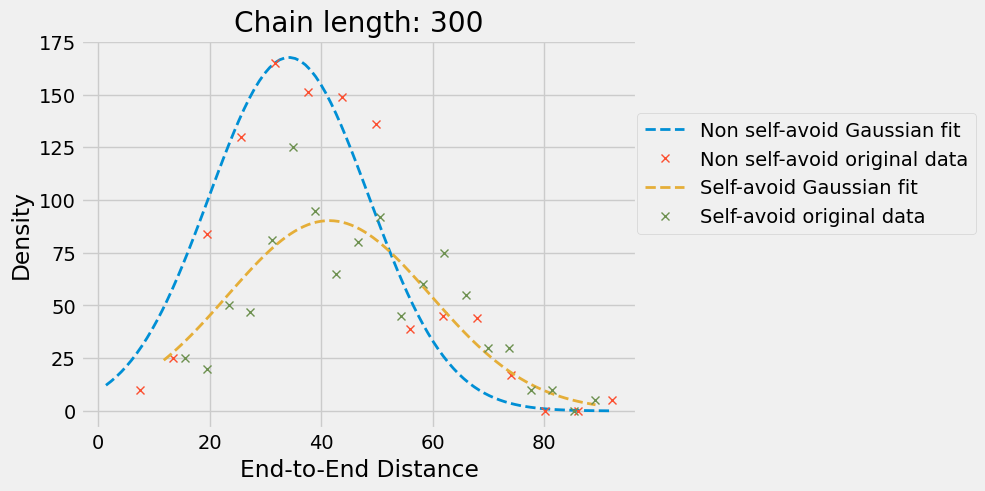

The root sqare mean value of the end-to-end distance is 39.25 for non self-avoid chains.
The root sqare mean value of the end-to-end distance is 46.31 for self-avoid chains.


In [ ]:
# @title End-to-End Distance {display-mode: "form" }

hist1, bin_edges1 = np.histogram(chains['e2eDistance'], bins=15)
bin_centers1 = 0.5 * (bin_edges1[:-1] + bin_edges1[1:])
initial_guess1 = [1, np.mean(bin_centers1), np.std(bin_centers1)]
popt1, pcov1 = curve_fit(gaussian, bin_centers1, hist1, p0=initial_guess1)
x_fit1 = np.linspace(bin_edges1[0], bin_edges1[-1], 100)
y_fit1 = gaussian(x_fit1, *popt1)
plt.plot(x_fit1, y_fit1, '--', linewidth=2, label='Non self-avoid Gaussian fit')
plt.plot(bin_edges1[1:], hist1, 'x', label='Non self-avoid original data')

hist2, bin_edges2 = np.histogram(selfAvoidChains['e2eDistance'], bins=20)
bin_centers2 = 0.5 * (bin_edges2[:-1] + bin_edges2[1:])
initial_guess2 = [1, np.mean(bin_centers2), np.std(bin_centers2)]
popt2, pcov2 = curve_fit(gaussian, bin_centers2, hist2, p0=initial_guess2)
x_fit2 = np.linspace(bin_edges2[0], bin_edges2[-1], 100)
y_fit2 = gaussian(x_fit2, *popt2)
plt.plot(x_fit2, y_fit2, '--', linewidth=2, label='Self-avoid Gaussian fit')
plt.plot(bin_edges2[1:], hist2, 'x', label='Self-avoid original data')

plt.xlabel('End-to-End Distance')
plt.ylabel('Density')
plt.title(f"Chain length: {chainLength}")
plt.legend(loc=(1,0.5))
plt.show()

print(f"The root sqare mean value of the end-to-end distance is {round(np.sqrt((chains['e2eDistance']**2).mean()), sigfigs = 4)} for non self-avoid chains.")
print(f"The root sqare mean value of the end-to-end distance is {round(np.sqrt((selfAvoidChains['e2eDistance']**2).mean()), sigfigs = 4)} for self-avoid chains.")

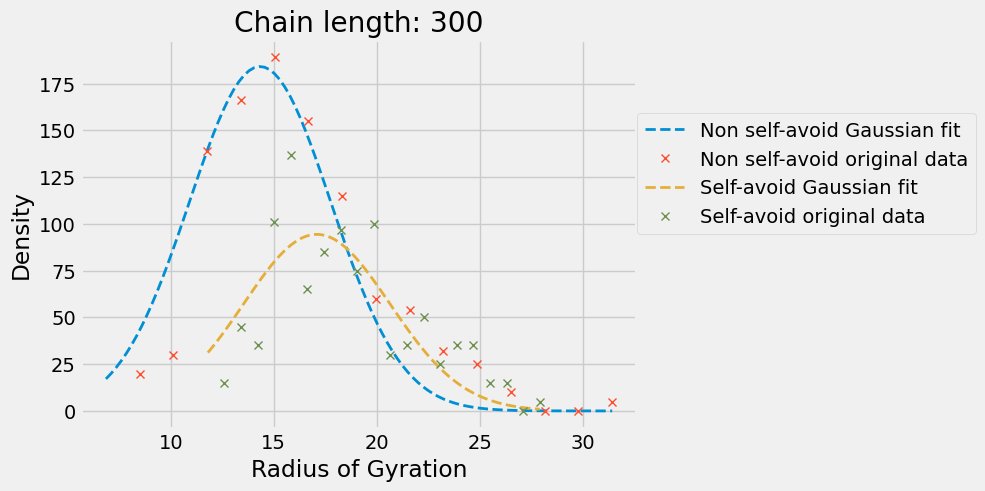

The root sqare mean value of the radius of gyration is 15.7 for non self-avoid chains.
The root sqare mean value of the radius of gyration is 18.33 for self-avoid chains.


In [ ]:
# @title Radius of Gyration {display-mode: "form" }

hist1, bin_edges1 = np.histogram(chains['radiusGyration'], bins=15)
bin_centers1 = 0.5 * (bin_edges1[:-1] + bin_edges1[1:])
initial_guess1 = [1, np.mean(bin_centers1), np.std(bin_centers1)]
popt1, pcov1 = curve_fit(gaussian, bin_centers1, hist1, p0=initial_guess1)
x_fit1 = np.linspace(bin_edges1[0], bin_edges1[-1], 100)
y_fit1 = gaussian(x_fit1, *popt1)
plt.plot(x_fit1, y_fit1, '--', linewidth=2, label='Non self-avoid Gaussian fit')
plt.plot(bin_edges1[1:], hist1, 'x', label='Non self-avoid original data')

hist2, bin_edges2 = np.histogram(selfAvoidChains['radiusGyration'], bins=20)
bin_centers2 = 0.5 * (bin_edges2[:-1] + bin_edges2[1:])
initial_guess2 = [1, np.mean(bin_centers2), np.std(bin_centers2)]
popt2, pcov2 = curve_fit(gaussian, bin_centers2, hist2, p0=initial_guess2)
x_fit2 = np.linspace(bin_edges2[0], bin_edges2[-1], 100)
y_fit2 = gaussian(x_fit2, *popt2)
plt.plot(x_fit2, y_fit2, '--', linewidth=2, label='Self-avoid Gaussian fit')
plt.plot(bin_edges2[1:], hist2, 'x', label='Self-avoid original data')

plt.xlabel('Radius of Gyration')
plt.ylabel('Density')
plt.title(f"Chain length: {chainLength}")
plt.legend(loc=(1,0.5))
plt.show()

print(f"The root sqare mean value of the radius of gyration is {round(np.sqrt((chains['radiusGyration']**2).mean()), sigfigs = 4)} for non self-avoid chains.")
print(f"The root sqare mean value of the radius of gyration is {round(np.sqrt((selfAvoidChains['radiusGyration']**2).mean()), sigfigs = 4)} for self-avoid chains.")



---



In [ ]:
#@title Copyright { display-mode: "form" }
import requests
from IPython.display import Markdown
copyright = requests.get("https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/master/copyright.md")
Markdown(copyright.text)

### MIT License  

Copyright (c) 2021 -- 2024 Yu Wang

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### Contact

Dr. Yu Wang  
Department of Chemistry  
Institute for Materials Research and Innovation  
University of Louisiana at Lafayette  
Lafayette, LA 70504  
Email: yuwang@louisiana.edu

### Acknowledgement

This project is sponsored by National Science Foundation (NSF-2142043). 


In [ ]:
# @title {display-mode: "form" }
links = requests.get("https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/refs/heads/master/links.md")
Markdown(links.text)

---

### Links

**[Home page of OVESET](https://wangyu16.github.io/PolymerScienceEducation/):** 

<img src="https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/refs/heads/master/img/QR_OVESET.svg" alt="OVESET Home Page" width="300">

**[Home page of Study Guide](https://hackmd.io/@YW2025/HJLiqoHRR)**

<img src="https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/refs/heads/master/img/QR_PolymerStudyGuide.svg" alt="Introduction to Polymer Science" width="300">

